# Исследование данных о продажах игр

В нашем распоряжении данные до 2016 года о продажах игр, оценки пользователей и экспертов, жанры и платформы.  Задача — выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. 

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

В ходе исследовательского анализа данных будут рассмотрены следующие аспекты:

1. Актуальный период для построения прогноза на 2017 год.
2. Определение платформ, лидирующих по продажам.
3. Оценка, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков.
4. Оценка распределения игр по жанрам.
5. Портреты пользователей каждого региона.
6. Проверка гипотез:
    - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
    - Средние пользовательские рейтинги жанров Action и Sports разные.

### Открытие файла с данными и изучение общей информации. 

In [1]:
#импортируем необходимые библиотеки
import pandas as pd
import seaborn as sns
from scipy import stats as st

In [2]:
data = pd.read_csv('/datasets/...')

In [3]:
#выводим 5 первых строк, чтобы взглянуть на саму таблицу
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
#выводим размеры ДФ
data.shape

(16715, 11)

In [5]:
#выводим общую информацию по ДФ
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Подготовка данных. 

**Замена названия столбцов (приведение к нижнему регистру).**

In [6]:
#для начала приведем все наименования столбцов к змеиному регистру
data.columns = data.columns.str.lower()

#также хочется сократить наименование слишком длинного столбца `Year_of_Release`
data = data.rename(
    columns={
        'year_of_release': 'release_year'
    }
)

**Преобразование данных в нужные типы.**

Возвращаясь к анализу информации, выведенной за счет метода `info()`, можно заметить, что в датафрейме содержится 5 колонок типа object, остальные 5 - к типу float64.

Хоть, на первый взгляд, в исследуемом массиве данных присутствуют колонки (в частности, release_year), значения которых могут принимать int, их преобразованием сейчас заниматься не будем - во-первых, такое преобразование не несет никакой пользы, кроме визуальной лаконичности, во-вторых, в таких колонках могут содержаться NaN, что приведет к ошибке. (Мы сделаем это позже, обработав пропуски в столбце)

В первую очередь, надо оценить, какие столбцы действительно относятся к object, а в каких, на самом деле, содержатся числовые значения. Преобразование таких столбцов критически важнее для дальнейшей правильной работы применяемых методов и функций.

В частности, таким столбцом является user_score, содержащий оценку пользователей.

In [7]:
#для начала, надо посмотреть все уникальные значения, содержащиеся в столбце
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Помимо числовых значений и известного нам NaN в данных также присутствует аббревиатура TBD - To Be Determined. Таким образом, это такие же пустые значения, как и NaN, которые, в свою очередь, помешают нам привести колонку к желаемому типу данных.

In [8]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = float('nan')

Теперь можно преобразовать столбец к правильному типу данных.

In [9]:
data['user_score'] = data['user_score'].astype(float)

Помимо совершенный действий, теоретически, можно было бы  еще сэкономить память, дополнительно изменяя типы данных с float64 на float32. Но так как датафрейм сам по себе не слишком большой, здесь этого делать не будем.

**Обработка пропусков.**

<AxesSubplot:>

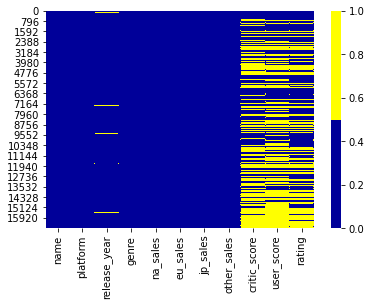

In [10]:
#стоит посмотреть количество пропусков в каждом из столбцов
#для лучшего визуального восприятия построим heatmap

# определяем цвета 
# желтый - пропущенные данные, синий - непропущенные
colours = ['#000099', '#ffff00'] 
sns.heatmap(data.isnull(), cmap=sns.color_palette(colours))

In [11]:
#для достоверности следует вывести также числовые показатели
data.isna().sum()

name               2
platform           0
release_year     269
genre              2
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score    8578
user_score      9125
rating          6766
dtype: int64

In [12]:
#хочется детально взглянуть на строки с пустыми названиями
data[data['name'].isna()]

,name,platform,release_year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


В выведенных строках отсутствует не только название - также нет таких важных показателей, как жанр игры и её рейтинги. При отсутствии таких ключевых значений указанные строки являются неинформативными, что позволяет их удалить без ущерба для всего датафрейма.

In [13]:
data = data.dropna(subset=['name'])

In [14]:
#взглянем теперь на строки с пустой датой релиза
data[data['release_year'].isna()]

,name,platform,release_year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,NaN,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


На первый взгляд, можно вычленить следующую группу строк:
- Игры, год релиза которых содержится в их названии.

In [15]:
possible_years = list(map(str, range(1950, 2017)))
game_has_year_mask = data['name'].apply(lambda name: any([year in name for year in possible_years]))

#выводим ДФ, в названии которого содержится год
data[game_has_year_mask]

,name,platform,release_year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
87,Star Wars Battlefront (2015),PS4,2015.0,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,NaN
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
238,Madden NFL 2005,PS2,2004.0,Sports,4.18,0.26,0.01,0.08,91.0,7.9,E
250,Winning Eleven: Pro Evolution Soccer 2007,PS2,2006.0,Sports,0.10,2.39,1.05,0.86,86.0,8.9,E
283,Madden NFL 2003,PS2,2002.0,Sports,3.36,0.21,0.01,0.56,95.0,7.7,E
...,...,...,...,...,...,...,...,...,...,...,...
16638,Tour de France 2014,PS3,2014.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,E
16658,Driving Simulator 2011,PC,2011.0,Racing,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16676,G1 Jockey 4 2008,PS3,2008.0,Sports,0.00,0.00,0.00,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN


Изначально было предположение, что можно заполнить пропуски в столбце с годом релиза годом, указанным в названии игры. Но при взгляде на таблицу выше видна некая особенность - некоторые игры, в названии которых присутствует год, на самом деле, выходили в предыдущем году. Легко определить закономерность, где год совпадает, а где различается, невозможно.

Учитывая, что пропуски составляют только 1.5% всего датафрейма, кажется более логичным удалить необходимые пропуски, чтобы потом не исказились данные в анализируемом актуальном периоде. 

In [16]:
data = data.dropna(subset=['release_year'])

#как я обещала, тут можем уже для красоты перевести столбец к int, так как значения NaN отсутствуют
data['release_year'] = data['release_year'].astype(int)

Далее перейдем к многочисленным пропускам с рейтингом от критиков и от пользователей. Заполнять медианным или средним значениями кажется неправильным - от игры к игре эти показатели могут слишком разниться и какая-то игра может незаслуженно стать недо- или переоцененной.

Однако, следует проверить корреляцию этих показателей. Так как даже если взгляды простых обывателей и профессиональных критиков не совпадают, то определенная взаимосвязь все же должна присутствовать. 

In [17]:
print('Корреляция оценки критиков и оценки пользователей составляет', data['critic_score'].corr(data['user_score']))

Корреляция оценки критиков и оценки пользователей составляет 0.5796706281932219


Гипотеза не подтвердилась - оценки критиков и пользователей не сильно коррелируют между собой. Так как нет ни одного другого видимого способа заполнить пропуски, которые, в свою очередь, в каждой из колонок составляют примерно 50% от всего датафрейма, оставим их пустыми и будем это учитывать в дальнейшем.

Последней не рассмотренной в рамках работы с пропусками колонкой является rating. Следует посмотреть, какие в принципе значения она может принимать.

In [18]:
data['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Как видно из списка значений, каких-либо описок нет - есть 8 разных категорий и уже привычные NaN. Таким образом, танный столбец доработки не требует.

**Добавление столбца.**

Для того, чтобы посчитать суммарные продажи во всех регионах и записать их в отдельный столбец, создадим столбец all_sales, в котором выведем сумму столбцов na_sales, eu_sales, jp_sales, other_sales по каждой игре.

In [19]:
data['all_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

In [20]:
#проверим, что получилось
data.head(10)

,name,platform,release_year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN,30.26
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E,28.32
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN,28.31


### Исследовательский анализ данных. 

**Посмотрим, сколько игр выпускалось в разные годы, чтобы выяснить, важны ли данные за все периоды.**

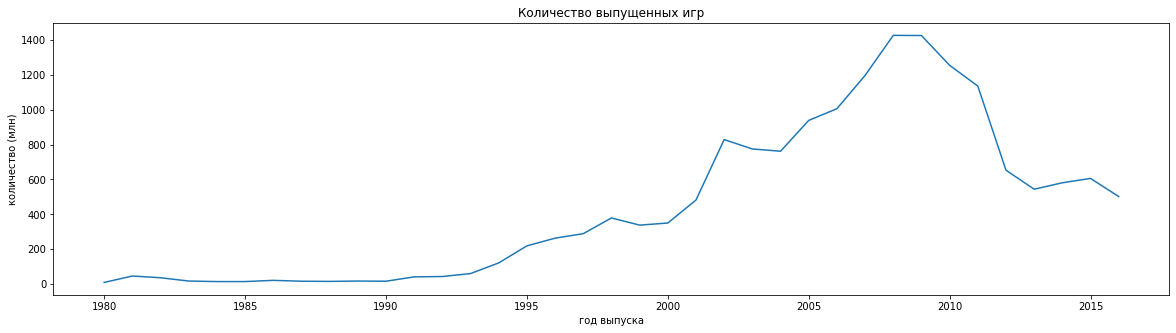

In [21]:
(
    data 
    .groupby('release_year')['release_year'] #группируем по году
    .count() #считаем количество игр
    .plot(
        figsize=(20, 5), 
        title='Количество выпущенных игр', 
        xlabel='год выпуска', 
        ylabel='количество (млн)') #строим график
);

Судя по графику, вплоть начала 21 века игр выпускалось недостаточно много для того, чтобы их брать в расчет и на основе этих данных делать какие-либо выводы. Однако, 16 лет - слишком большой период для того, чтобы называть его актуальным и на основе его делать прогнозы на 2017 год. Тем не менее, он может быть репрезентативным для того, чтобы смотреть на картину в целом.

Для уточнения "акутального периода" необходимо построить дополнительный график, определяющий, за какой характерный срок появляются новые и исчезают старые платформы.

**Посмотрим, за какой характерный срок появляются новые и исчезают старые платформы.**

Для начала следует выберать платформы с наибольшими суммарными продажами. Для того, чтобы наиболее точно ответить на вопрос о том, за какой срок появляются и исчезают платформы, возьмем топ-10 платформ с наибольшим количеством продаж.

In [22]:
top_platforms = (
    data
    .groupby('platform')['all_sales'] #группируем по платформе
    .sum() #считаем общее количество продаж
    .sort_values(ascending=False) #сортируем по уменьшению
).head(10)

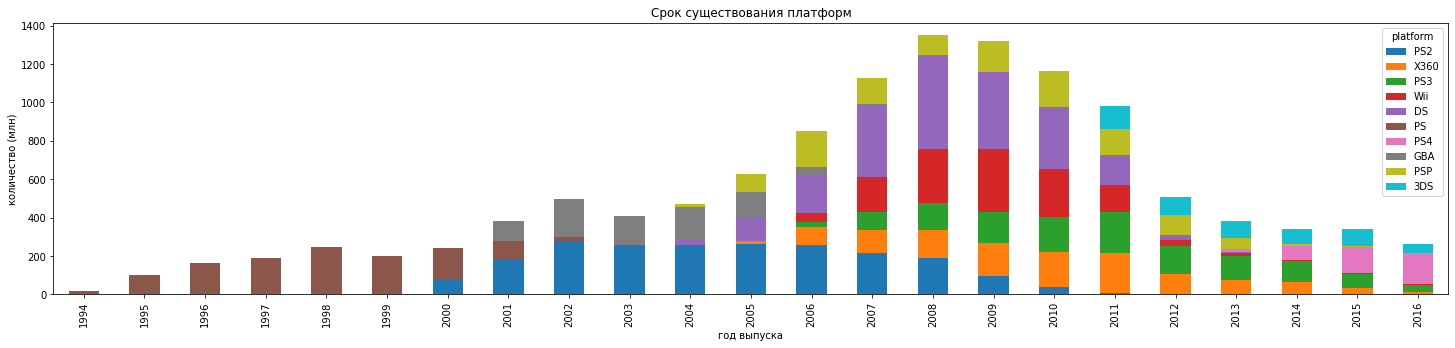

In [23]:
#создадим сводную таблицу по всем платформам и годам, когда на них выходили игры
data_platform = data.pivot_table(values='name', index='release_year', columns='platform', aggfunc='count')

#из созданной таблицы возьмем информацию только по интересующим нас платформам
data_top_platform = data_platform[top_platforms.index].copy()

#посчитаем сумму игр за год (так как мы выбрали только самые популярные игры, наверняка в начале ДФ будут 0)
data_top_platform['sum_per_year'] = data_top_platform.sum(axis=1)

#строим график по самым популярным платформам и годам, когда вышло хотя бы более 10 игр (не копий)
(
    data_top_platform[data_top_platform['sum_per_year'] > 10][top_platforms.index]
    .plot
    .bar(
        stacked=True,
        figsize=(25, 5),
        title='Срок существования платформ',
        xlabel='год выпуска',
        ylabel='количество (млн)'
    )
);

In [48]:
data_top_platform[data_top_platform['sum_per_year'] > 10][top_platforms.index]

platform,PS2,X360,PS3,Wii,DS,PS,PS4,GBA,PSP,3DS
release_year,,,,,,,,,,
1994,NaN,NaN,NaN,NaN,NaN,17.0,NaN,NaN,NaN,NaN
1995,NaN,NaN,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN
1996,NaN,NaN,NaN,NaN,NaN,164.0,NaN,NaN,NaN,NaN
1997,NaN,NaN,NaN,NaN,NaN,188.0,NaN,NaN,NaN,NaN
1998,NaN,NaN,NaN,NaN,NaN,248.0,NaN,NaN,NaN,NaN
1999,NaN,NaN,NaN,NaN,NaN,200.0,NaN,NaN,NaN,NaN
2000,82.0,NaN,NaN,NaN,NaN,160.0,NaN,1.0,NaN,NaN
2001,185.0,NaN,NaN,NaN,NaN,91.0,NaN,107.0,NaN,NaN
2002,280.0,NaN,NaN,NaN,NaN,20.0,NaN,198.0,NaN,NaN


Благодаря построенному графику можно сделать вывод, что в среднем платформы "живут" около 7-8 лет.
Также можно сделать вывод, что высока вероятность того, что в 2017 году большинство игр будет выпущено на PS4, некоторое количество на 3DS, в то время как X360 и PS3 уже "доживают" свое время.

**Актуальный период.**

На основе двух построенных графиков можно сделать следующие выводы относительно *актуального периода*:
1. Игровая сфера начала активно развиваться с 1995 года и набирала свою популярность вплоть до 2009 года. С 2009 до 2016 наблюдается спад в производстве игр.
2. В игровой сфере есть множество платформ, которые появляются, набирают популярность и в дальнейшем исчезают - в среднем, их жизненный цикл длится около 7 лет, половину из которых они находятся в пике своей популярности. На момент проведения исследования (2016 год с целью прогноза на 2017) как раз набирает популярность платформа PS4, впервые появившаяся в 2013 году.

Таким образом, для наиболее точного ответа на поставленную задачу видится целесообразным взять временной промежуток с 2011 по 2016 год - начало промежутка является пиком развития игровой сферы по сравнению с предыдущими годами, но популярность таких платформ, как Wii, DS и PSP уже прошла, что поможет нам строить более точные прогнозы без искажения показателей из-за больших продаж на платформах, которые к 2017 году уже теряют или потеряли вовсе свою актуальность.

In [24]:
#определим датафрейм, с которым в дальнейшем будем работать
data_upd = data[(data['release_year'] >= 2011)].reset_index()

#проверим, с каким датафреймом предстоит работать
data_upd.shape

(4022, 13)

Таким образом, для проверки гипотез будет необходима четверть от изначального датафрейма, с которой мы и будем работать.

**Анализ платформ, лидирующих по продажам, оценка направления их движения.**

Для ответа на поставленный вопрос необходимо составить сводную таблицу по объемам продаж со всех платформ за ранее определенный актуальный период.

In [25]:
sells_platforms = data_upd.pivot_table(values='all_sales', index='release_year', columns='platform', aggfunc='sum')

sells_platforms

platform,3DS,DS,PC,PS2,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
release_year,,,,,,,,,,,,
2011,63.20,26.18,35.03,0.45,156.78,NaN,17.82,4.63,59.65,NaN,143.84,NaN
2012,51.36,11.01,23.22,NaN,107.36,NaN,7.69,16.19,21.71,17.56,99.74,NaN
2013,56.57,1.54,12.38,NaN,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
2014,43.76,NaN,13.28,NaN,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,NaN,8.52,NaN,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,NaN,5.25,NaN,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


In [26]:
#уберем из таблицы те платформы, игры на которые в 2016 не продавались
sells_platforms_act = sells_platforms[sells_platforms.loc[2016][~sells_platforms.loc[2016].isna()].index]
sells_platforms_act

platform,3DS,PC,PS3,PS4,PSV,Wii,WiiU,X360,XOne
release_year,,,,,,,,,
2011,63.20,35.03,156.78,NaN,4.63,59.65,NaN,143.84,NaN
2012,51.36,23.22,107.36,NaN,16.19,21.71,17.56,99.74,NaN
2013,56.57,12.38,113.25,25.99,10.59,8.59,21.65,88.58,18.96
2014,43.76,13.28,47.76,100.00,11.90,3.75,22.03,34.74,54.07
2015,27.78,8.52,16.82,118.90,6.25,1.14,16.35,11.96,60.14
2016,15.14,5.25,3.60,69.25,4.25,0.18,4.60,1.52,26.15


Исходя из полученной таблицы видно, что в 2016 году игры выпускались и продавались на 9 платформах. Для того, чтобы оценить тенденцию продаж, построим график.

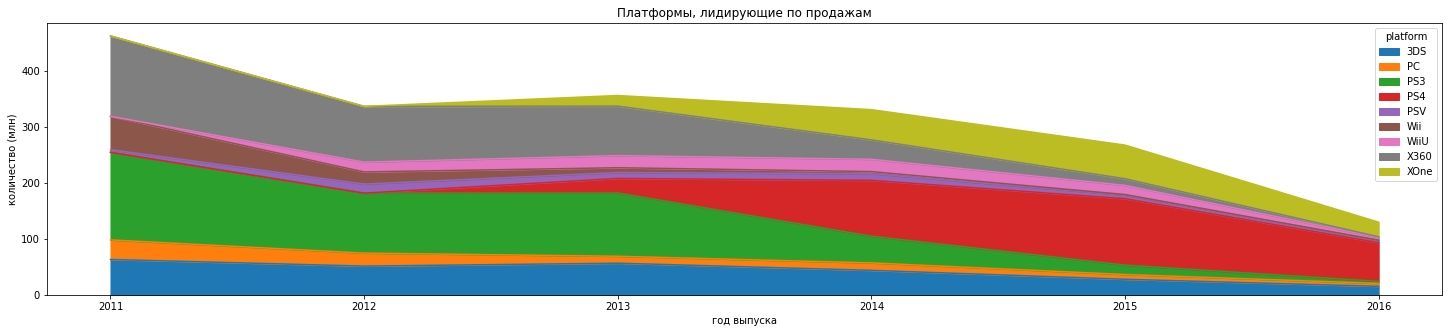

In [27]:
(
    sells_platforms_act.plot
    .area(
        stacked=True, 
        figsize=(25, 5), 
        title='Платформы, лидирующие по продажам', 
        xlabel='год выпуска', 
        ylabel='количество (млн)')
);

Можно сделать вывод, что явными лидерами  по продаже компьютерных игр, на данный момент, являются XOne и PS4, в то время как обе платформы существуют на рынке с 2013 года, тенденция PS4 выглядит более многообещающей, чем его конкурента в лице XOne. Тем не менее, на мой взгляд, не стоит сбрасывать со счетов платформу 3DS, продажи которой хоть и меньше 2 других платформ, но отличаются относительной стабильностью с 2011 года. Также критически важно отметить общую тенденцию снижения продаж компьютерных игр по всем платформам. Даже выбранные платформы-лидеры показывают снижение общей суммы продаж компьютерных игр по сравнению с предыдущими годами.

**Построение и анализ графика «ящик с усами» по глобальным продажам игр в разбивке по платформам.**

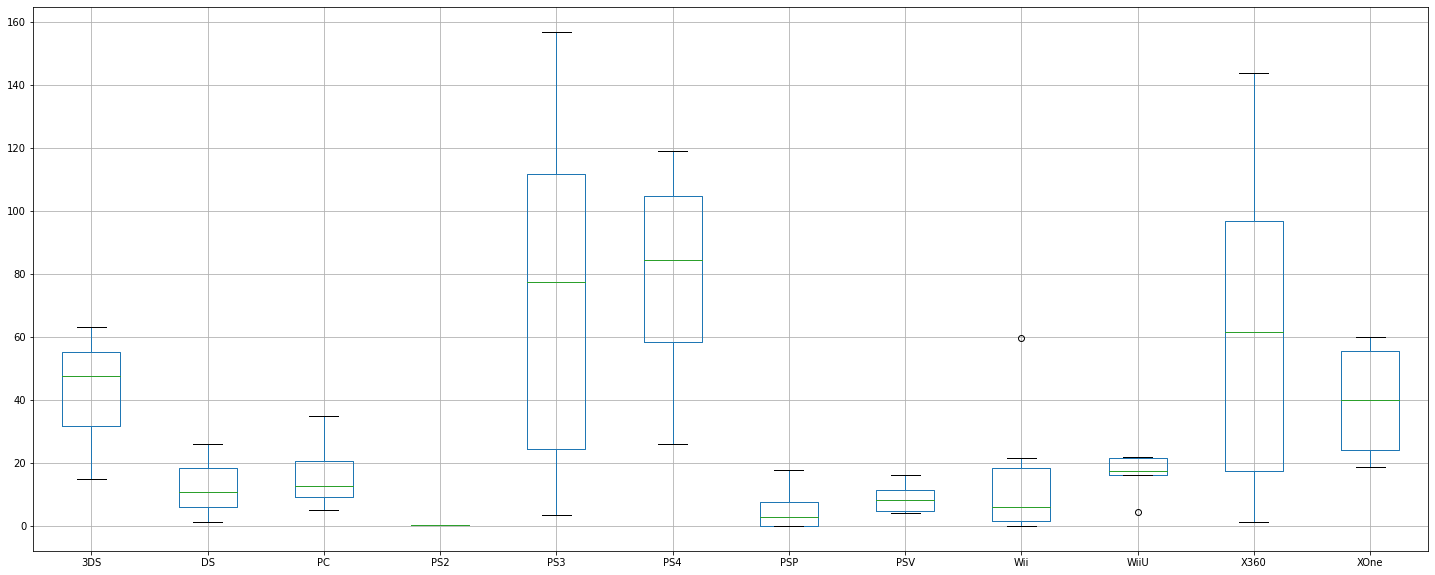

In [28]:
#обратимся к ранее составленной сводной таблице и применим метод boxplot ко всем колонкам одновременно 
sells_platforms.boxplot(figsize=(25, 10));

Данный график хорошо иллюстрирует и позволяет сравнивать медианные значения продаж для каждой из платформ, их нормальные значения и выбросы, если они есть. 

Стоит напомнить, что актуальный период брался с пиковых значений и охватывает весь нисходящий тренд. Поэтому помимо абсолютных числовых показателей для того, чтобы правильно трактовать построенный выше график, необходимо обращаться к годам, когда были достигнуты те или иные показатели. 

Так, в настоящем графике отражено 3 поколения PS, и наилучшими показателями обладает PS4, медианное значения которого находится на уровне 85. Однако, разброс нормальных значений у PS3 гораздо больше. Тем не менее, не следует забывать о продолжительности "жизни" игровых платформ. Если обратиться к сводной таблице, можно заметить тенденцию, что PS3 "доживает" свою игровую жизнь, в то время как пришедший на его замену PS4 только набирает обороты.

То же прослеживается и у менее успешной приставки производства Nintendo - Wii. Помимо того, что её успех в 2011 году на "ящике с усами" считается как выброс, так и появление WiiU сказалось на продажах приставки предыдущего поколения и уже отбросило своего предшественника на более низкие показатели.

Рассматривая платформы, принадлежащие Xbox, видно, что медиана у Х360 располагается на уровне 60, в то время как у XOne она колеблется около 40. Тем не менее, как и в случае с двумя примерами выше, XOne - это новшество, которое только набирает свои обороты.

PSV, пришедший на замену популярного в 2011 году PSP, не смог повторить успеха своего предшественника и на закате своего существования показал продажи немного хуже, чем у PSP.

3DC также не удалось повторить успех DC нулевых, тем не менее, он показывает лучшие значения согласно графику - медианное значение продаж почти достигает 50, и стабильность, отраженная на графике выше, делает его одной из привлекательной платформ для инвестирования.

Помимо семейств игровых платформ, остался персональный компьютер, разброс значений которого невелик и говорит об относительном постоянстве - нормальные значения мировых продаж, колеблющиеся в пределах "усов", равняются 5 и 35.

**Влияние на продажи внутри одной популярной платформы отзывов пользователей и критиков.**

Отзывы пользователей и критиков хранятся в столбцах user_score и critic_score, соответственно. Оценки критиков - это целые числа до 100, пользователей - числа с плавающей точкой до 10. Для того, чтобы найти корреляцию между продажами и отзывами, необходимо добавить столбец со средней оценкой и посчитать саму корреляцию.

In [29]:
#для начала переведем оценки пользователей в одинаковую с оценками критиков величину
data_upd['user_score'] = data_upd['user_score'] * 10

#теперь добавим столбец как среднее оценки критиков и пользователей
data_upd['total_score'] = (data_upd['user_score'] + data_upd['critic_score']) / 2

#выведем, что получилось
data_upd.head()

,index,name,platform,release_year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales,total_score
0,16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,82.0,M,21.05,89.5
1,23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,81.0,M,16.27,89.0
2,29,Call of Duty: Modern Warfare 3,X360,2011,Shooter,9.04,4.24,0.13,1.32,88.0,34.0,M,14.73,61.0
3,31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63,NaN
4,33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NaN,14.60,NaN


Корреляция отзывов и продаж для PS4 равна 0.19233840669826302
Корреляция отзывов критиков и продаж для PS4 равна 0.40656790206178095
Корреляция отзывов пользователей и продаж для PS4 равна -0.03195711020455641


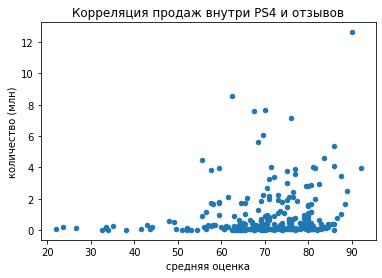

In [30]:
#построим диаграмму рассеяния для PS4
data_upd[data_upd['platform'] == 'PS4'].plot(
    x='total_score', 
    y='all_sales', 
    kind='scatter',
    title='Корреляция продаж внутри PS4 и отзывов',
    xlabel='средняя оценка',
    ylabel='количество (млн)') 

#и посчитаем корреляцию
corr_all_ps = data_upd[data_upd['platform'] == 'PS4']['total_score'].corr(data_upd[data_upd['platform'] == 'PS4']['all_sales'])
corr_critic_ps = data_upd[data_upd['platform'] == 'PS4']['critic_score'].corr(data_upd[data_upd['platform'] == 'PS4']['all_sales'])
corr_user_ps = data_upd[data_upd['platform'] == 'PS4']['user_score'].corr(data_upd[data_upd['platform'] == 'PS4']['all_sales'])
print('Корреляция отзывов и продаж для PS4 равна', corr_all_ps)
print('Корреляция отзывов критиков и продаж для PS4 равна', corr_critic_ps)
print('Корреляция отзывов пользователей и продаж для PS4 равна', corr_user_ps)

Корреляция отзывов и продаж для XOne равна 0.17856743422301058
Корреляция отзывов критиков и продаж для XOne равна 0.4169983280084017
Корреляция отзывов пользователей и продаж для XOne равна -0.06892505328279411


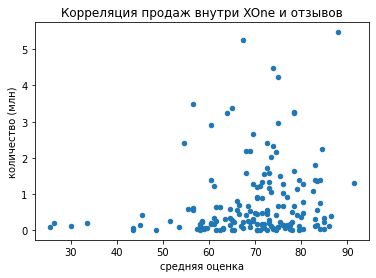

In [31]:
#сделаем то же самое для XOne 
data_upd[data_upd['platform'] == 'XOne'].plot(
    x='total_score', 
    y='all_sales', 
    kind='scatter',
    title='Корреляция продаж внутри XOne и отзывов',
    xlabel='средняя оценка',
    ylabel='количество (млн)') 

#и посчитаем корреляцию
corr_xone = data_upd[data_upd['platform'] == 'XOne']['total_score'].corr(data_upd[data_upd['platform'] == 'XOne']['all_sales'])
corr_critic_xone = data_upd[data_upd['platform'] == 'XOne']['critic_score'].corr(data_upd[data_upd['platform'] == 'XOne']['all_sales'])
corr_user_xone = data_upd[data_upd['platform'] == 'XOne']['user_score'].corr(data_upd[data_upd['platform'] == 'XOne']['all_sales'])
print('Корреляция отзывов и продаж для XOne равна', corr_xone)
print('Корреляция отзывов критиков и продаж для XOne равна', corr_critic_xone)
print('Корреляция отзывов пользователей и продаж для XOne равна', corr_user_xone)

Проанализировав 2 наиболее популярные платформы и получив примерно одинаковые результаты, можно сделать вывод о том, что корреляция между объемом продаж и отзывами пользователей отсутствует вообще - по всей видимости, люди при принятии решения о покупке компьютерной игры не опираются на опыт таких же игроков, чего нельзя сказать об отзывах критиков. В обоих случаях корреляция Пирсона равна 0.4, что говорит об умеренной силы корреляционной связи. 

Таким образом, к оценке профессионалов потенциальные покупатели прислушиваются и, как видно, учитывают при совершении покупок. Тем не менее, отзывы явно не являются первостепенным фактором при принятии решения о приобретении компьютерной игры. 

Корреляция отзывов и продаж для 3DS равна 0.3033155494603089
Корреляция отзывов критиков и продаж для 3DS равна 0.3487397305984834
Корреляция отзывов пользователей и продаж для 3DS равна 0.22207843643390882


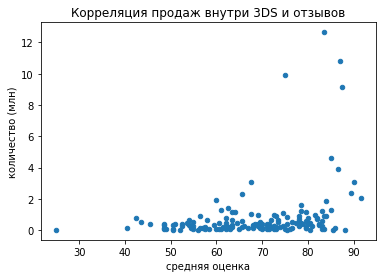

In [32]:
#проанализируем несколько других платформ, не являющимися лидерами
#например, 3DS
data_upd[data_upd['platform'] == '3DS'].plot(x='total_score', 
                                             y='all_sales', 
                                             kind='scatter',
                                             title='Корреляция продаж внутри 3DS и отзывов',
                                             xlabel='средняя оценка',
                                             ylabel='количество (млн)'
                                            ) 

#и посчитаем корреляцию
corr_ds = data_upd[data_upd['platform'] == '3DS']['total_score'].corr(data_upd[data_upd['platform'] == '3DS']['all_sales'])
corr_critic_ds = data_upd[data_upd['platform'] == '3DS']['critic_score'].corr(data_upd[data_upd['platform'] == '3DS']['all_sales'])
corr_user_ds = data_upd[data_upd['platform'] == '3DS']['user_score'].corr(data_upd[data_upd['platform'] == '3DS']['all_sales'])
print('Корреляция отзывов и продаж для 3DS равна', corr_ds)
print('Корреляция отзывов критиков и продаж для 3DS равна', corr_critic_ds)
print('Корреляция отзывов пользователей и продаж для 3DS равна', corr_user_ds)

Корреляция отзывов и продаж для PC равна 0.10782285178810057
Корреляция отзывов критиков и продаж для PC равна 0.3141847396903631
Корреляция отзывов пользователей и продаж для PC равна -0.04896683233511961


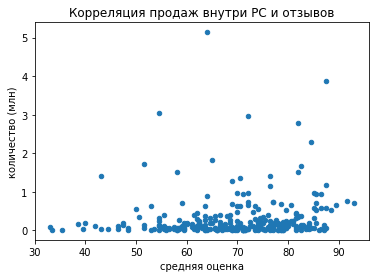

In [33]:
#и бессмертный PC
data_upd[data_upd['platform'] == 'PC'].plot(x='total_score', 
                                            y='all_sales', 
                                            kind='scatter',
                                            title='Корреляция продаж внутри PC и отзывов',
                                            xlabel='средняя оценка',
                                            ylabel='количество (млн)'
                                           ) 

#и посчитаем корреляцию
corr_pc = data_upd[data_upd['platform'] == 'PC']['total_score'].corr(data_upd[data_upd['platform'] == 'PC']['all_sales'])
corr_critic_pc = data_upd[data_upd['platform'] == 'PC']['critic_score'].corr(data_upd[data_upd['platform'] == 'PC']['all_sales'])
corr_user_pc = data_upd[data_upd['platform'] == 'PC']['user_score'].corr(data_upd[data_upd['platform'] == 'PC']['all_sales'])
print('Корреляция отзывов и продаж для PC равна', corr_pc)
print('Корреляция отзывов критиков и продаж для PC равна', corr_critic_pc)
print('Корреляция отзывов пользователей и продаж для PC равна', corr_user_pc)

Для менее популярных платформ никаких других выводов сделать нельзя. 

Таким образом, вывод для популярных и не очень платформ един - на продажи игр влияют только отзывы критиков и то же слишком сильно - отзывы не являются первостепенной причиной для покупки компьютерной игры или отказа от нее.

**Общее распределение игр по жанрам.**

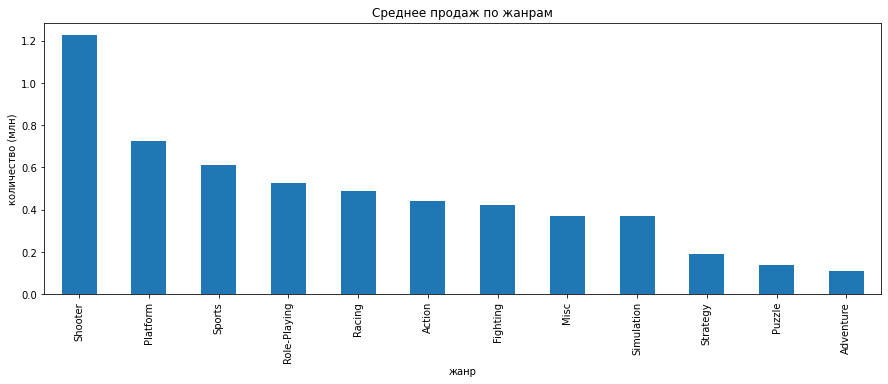

In [34]:
(
    data_upd.groupby('genre')['all_sales']
    .mean()
    .sort_values(ascending=False)
    .plot.bar(
        figsize=(15, 5), 
        title='Cреднее продаж по жанрам', 
        xlabel='жанр', 
        ylabel='количество (млн)'
    )
);


Самым прибыльным жанром среди компьютерных игр оказался шутер, в то время, как наименее популярным - игры-путешествия. Разница между самым популярным и непопулярным - почти в 6 раз. 

### Портрет пользователя каждого региона. 

Для составления портрета пользователя каждого региона необходимо проанализировать популярные платформы, жанры и  рейтинг ESRB. 

**Пользователь из Северной Америки.**

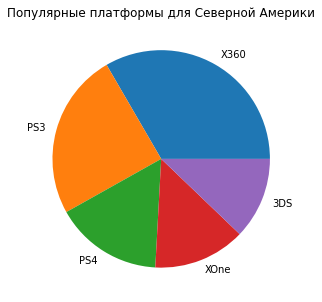

In [35]:
#определим наиболее популярные платформы для Северной Америки
(
    data_upd.groupby('platform')['na_sales']
    .sum()
    .sort_values(ascending=False)
    .head()
    .plot.pie(
        figsize=(10, 5), 
        title='Популярные платформы для Северной Америки',
        ylabel=''
    )
);

Исходя из полученной диаграммы можно сделать вывод, что пользователи из Северной Америки отдают предпочтения таким платформам, как PS и XBox. 1/8 от всех продаж уходит Nintendo.

Большую долю занимает X360, потом следует PS3, XOne и PS4, пришедшие на замену основным платформам, пока еще не набрали такого количества продаж. Тем не менее, не стоит забыывать, что с их появлением продажи X360 и PS3 резко сократились.

Таким образом, данным графиком подтверждается сделанный ранее вывод о том, что наиболее прибыльными площадками являются XOne, PS4 и хоть с наименьшими продажами, но стабильный 3DS.

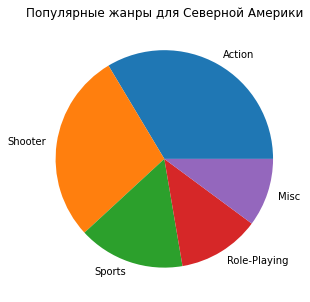

In [36]:
#определим наиболее популярные жанры для Северной Америки
(
    data_upd.groupby('genre')['na_sales']
    .sum()
    .sort_values(ascending=False)
    .head()
    .plot.pie(
        figsize=(10, 5), 
        title='Популярные жанры для Северной Америки',
        ylabel=''
    )
);

В Северной Америке наиболее популярными жанрами являются экшн и шутеры, далее примерно одинаково распределены ролевые игры и спортивные, что тоже в целом соответствует общему распределению жанров в мире.

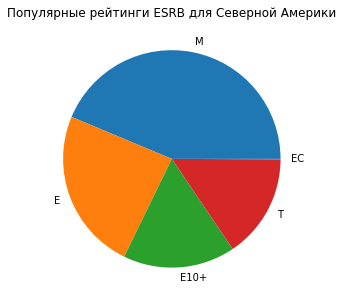

In [37]:
#определим наиболее популярные рейтинги ESRB для Северной Америки
(
    data_upd.groupby('rating')['na_sales']
    .sum()
    .sort_values(ascending=False)
    .head()
    .plot.pie(
        figsize=(10, 5), 
        title='Популярные рейтинги ESRB для Северной Америки',
        ylabel=''
    )
);

Подавляющее большинство игр, которые предпочитают пользователи из Северной Америки, помечено организацией ESRB "М", что говорит о наличии жестокости в играх, сцен с кровью и ненормативной лексики - очевидные характеристики предпочитаемых жанров экшн и шутеров. Далее большой объем игр попадает под маркировку "Е" и "Е10+", которые, наоборот, подходят пользователям любого возраста (или 10+). Последняя часть графика "Т" отвечает за игры, позволительные пользователям возраста 13+, которые уже могут содержать минимальное носилие, кровь или ненормативную лексику.

**Пользователь из Европы.**

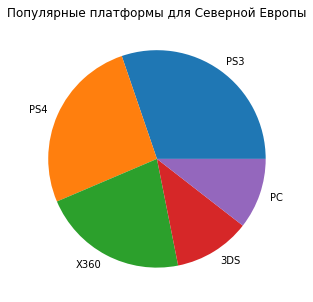

In [38]:
#определим наиболее популярные платформы для Европы
(
    data_upd.groupby('platform')['eu_sales']
    .sum()
    .sort_values(ascending=False)
    .head()
    .plot.pie(
        figsize=(10, 5), 
        title='Популярные платформы для Северной Европы',
        ylabel=''
    )
);

Пользователи в Европе отдают свое явное предпочтение PS - более половины продаж приходится на PS старого и нового поколения. Чуть меньше четверти продаж занимает XBox, последнюю четверть делит между собой Nintendo и, неожиданно, персональный компьютер.

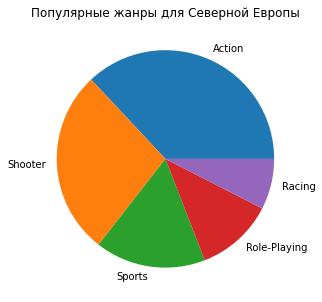

In [39]:
#определим наиболее популярные жанры для Европы
(
    data_upd.groupby('genre')['eu_sales']
    .sum()
    .sort_values(ascending=False)
    .head()
    .plot.pie(
        figsize=(10, 5), 
        title='Популярные жанры для Северной Европы',
        ylabel=''
    )
);

В Европе, как и в Северной Америке, наибольшие предпочтения пользователи отдают таким жанрам игр, как экшн и шутеры. Спортивные и ролевые игры также занимают свое место в топ-5, который завершают гонки.

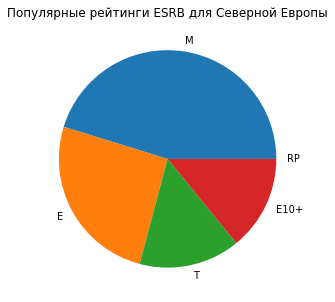

In [40]:
#определим наиболее популярные рейтинги ESRB для Европы
(
    data_upd.groupby('rating')['eu_sales']
    .sum()
    .sort_values(ascending=False)
    .head()
    .plot.pie(
        figsize=(10, 5), 
        title='Популярные рейтинги ESRB для Северной Европы',
        ylabel=''
    )
);

Как и в Северной Америке, благодаря предпочтениям по жанрам, конечно же, наиболее популярными играми среди пользователей являются игры с маркировкой "М" - mature. Далее следуют игры для всех и для всех 10+ возраста, завершает этот топ пометка teenage. Все подробное описание представлено в исследовании портрета пользователя из Северной Америки.

**Пользователь из Японии.**

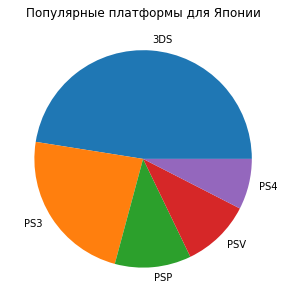

In [41]:
#определим наиболее популярные платформы для Японии
(
    data_upd.groupby('platform')['jp_sales']
    .sum()
    .sort_values(ascending=False)
    .head()
    .plot.pie(
        figsize=(10, 5), 
        title='Популярные платформы для Японии',
        ylabel=''
    )
);

У пользователей из Японии абсолютно неожиданные показатели - большую часть продаж (почти половину) забрал Nintendo благодаря своему 3DS. Далее больше половины отдано PS, а третье место уходит PSP и пришедшему ему на замену PSV.

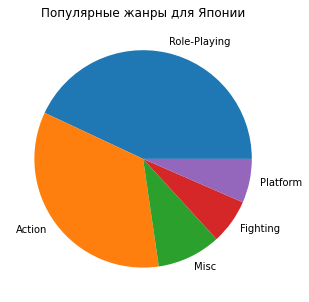

In [42]:
#определим наиболее популярные жанры для Японии
(
    data_upd.groupby('genre')['jp_sales']
    .sum()
    .sort_values(ascending=False)
    .head()
    .plot.pie(
        figsize=(10, 5), 
        title='Популярные жанры для Японии',
        ylabel=''
    )
);

Пользователям из Японии более всего интересны ролевые игры, далее следуют экшн, завершают топ игры-платформеры и единственные игры, сопряженные с насилием - драки.

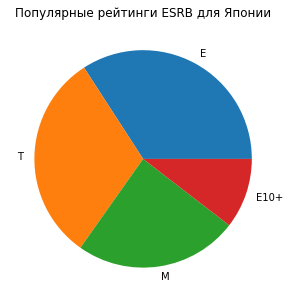

In [43]:
#определим наиболее популярные рейтинги ESRB для Европы
(
    data_upd.groupby('rating')['jp_sales']
    .sum()
    .sort_values(ascending=False)
    .head()
    .plot.pie(
        figsize=(10, 5), 
        title='Популярные рейтинги ESRB для Японии',
        ylabel=''
    )
);

Из-за кардинально отличных от Америки и Европы предпочтений, в Японии более 2/3 игр имеют маркировку для всех или для тинейджеров. Тем не менее, достаточно неожиданно, учитывая малую долю игры с жанром драки, чуть менее 1/3 занимают игры с пометкой mature - можно предположить, что такая маркировка связана не с наличием в игре насилия или крови.

### Проверка гипотез. 

**Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.**

Нулевая гипотеза:
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Альтернативная гипотеза:
- Средние пользовательские рейтинги платформ Xbox One и PC не одинаковые.

Используем специальный метод для проверки *гипотезы о равенстве среднего двух генеральных совокупностей* по взятым из них выборкам.

Указанные метод подходит, так как:
1. Генеральные совокупности не должны зависеть друг от друга.
2. Выборочные средние  нормально распределены.


In [44]:
mean_user_score_xone = data_upd[data_upd['platform'] == 'XOne']['user_score'].dropna() #первая совокупность
mean_user_score_pc = data_upd[data_upd['platform'] == 'PC']['user_score'].dropna() #вторая совокупность


#посмотрим размеры выборок для того, чтобы правильно проверить гипотезу
print(mean_user_score_xone.shape, mean_user_score_pc.shape)

(182,) (307,)


In [45]:
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    mean_user_score_xone, 
    mean_user_score_pc,
    equal_var = False #пишем False, потому что выборки почти в 2 раза различаются и нет уверенности, что дисперсии одинаковые
)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.613071224763855
Не получилось отвергнуть нулевую гипотезу


Таким образом, исходя из имеющихся данных нет оснований отвергать гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

**Средние пользовательские рейтинги жанров Action и Sports разные.**

Нулевая гипотеза:
- Средние пользовательские рейтинги жанров Action и Sports одинаковые.

Альтернативная гипотеза:
- Средние пользовательские рейтинги жанров Action и Sports не одинаковые.

Используем тот же метод для проверки *гипотезы о равенстве среднего двух генеральных совокупностей* по взятым из них выборкам.

In [46]:
mean_user_score_action = data_upd[data_upd['genre'] == 'Action']['user_score'].dropna() #первая совокупность
mean_user_score_genre = data_upd[data_upd['genre'] == 'Sports']['user_score'].dropna() #вторая совокупность

#посмотрим размеры выборок для того, чтобы правильно проверить гипотезу
print(mean_user_score_xone.shape, mean_user_score_pc.shape)

(182,) (307,)


In [47]:
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    mean_user_score_action, 
    mean_user_score_genre,
    equal_var = False #пишем False, потому что выборки почти в 2 раза различаются и нет уверенности, что дисперсии одинаковые
)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 8.285648549432146e-19
Отвергаем нулевую гипотезу


Таким образом, исходя из имеющихся данных нет оснований отвергать гипотезу о том, что средние пользовательские рейтинги жанров Action и Sports разные.

### Общий вывод. 

Целью исследования было научиться определять рыночную стоимость объектов недвижимости. Задача — выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

***Перед проведением исследования были поставлены следующие задачи:***
1. Определить, какие платформы лидируют по продажам, растут или падают? Выбрать несколько потенциально прибыльных платформ.
2. Оценить, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков.
3. Построить общее распределение игр по жанрам.
4. Составить портрет пользователя каждого региона.
5. Проверить гипотезу: средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
6. Проверить гипотезу: средние пользовательские рейтинги жанров Action и Sports разные.

В результате, выявлены следующие закономерности:

***Потенциально прибыльные платформы.***

Cогласно построенному в ходе исследования графику явными лидерами  по продаже компьютерных игр, на данный момент, являются XOne и PS4, в то время как обе платформы существуют на рынке с 2013 года, тенденция PS4 выглядит более многообещающей, чем его конкурента в лице XOne. Тем не менее, на мой взгляд, не стоит сбрасывать со счетов платформу 3DS, продажи которой хоть и меньше 2 других платформ, но отличаются относительной стабильностью с 2011 года. Также критически важно отметить общую тенденцию снижения продаж компьютерных игр по всем платформам. Даже выбранные платформы-лидеры показывают снижение общей суммы продаж компьютерных игр по сравнению с предыдущими годами.

***Влияние на продажи внутри одной популярной платформы отзывы пользователей и критиков.***

Проанализировав 4 игровые платформы, как наиболее популярные, так и не очень успешные и получив примерно одинаковые результаты, можно сделать вывод о том, что корреляция между объемом продаж и отзывами пользователей отсутствует вообще - по всей видимости, люди при принятии решения о покупке компьютерной игры не опираются на опыт таких же игроков, чего нельзя сказать об отзывах критиков. Во всех случаях корреляция Пирсона близится к 0.4, что говорит об умеренной силы корреляционной связи. 

Таким образом, к оценке профессионалов потенциальные покупатели прислушиваются и, как видно, учитывают при совершении покупок. Тем не менее, отзывы явно не являются первостепенным фактором при принятии решения о приобретении компьютерной игры. 

***Общее распределение игр по жанрам.***

Самым прибыльным жанром среди компьютерных игр оказался экшн, в то время, как наименее популярным - пазлы. Разница между самым популярным и непопулярным - почти в 7 раз. Очевидно, люди играют в компьютерные игры для того, чтобы расслабиться и отдохнуть после тяжелого дня, и игры, требующие минимальной мозговой активности для них более привлекательны.

***Портрет пользователя каждого региона.***

*Пользователь из Северной Америки.*

- Пользователи из Северной Америки отдают предпочтения таким платформам, как PS и XBox. 1/8 от всех продаж уходит Nintendo.
- В Северной Америке наиболее популярными жанрами являются экшн и шутеры, далее примерно одинаково распределены ролевые игры и спортивные.
- Подавляющее большинство игр, которые предпочитают пользователи из Северной Америки, помечено организацией ESRB "М". Далее большой объем игр попадает под маркировку "Е" и "Е10+", которые, наоборот, подходят пользователям любого возраста (или 10+). Последняя часть графика "Т" отвечает за игры, позволительные пользователям возраста 13+, которые уже могут содержать минимальное носилие, кровь или ненормативную лексику.

*Пользователь из Европы.*

- Пользователи в Европе отдают свое явное предпочтение PS - более половины продаж приходится на PS старого и нового поколения. Чуть меньше четверти продаж занимает XBox, последнюю четверть делит между собой Nintendo и, неожиданно, персональный компьютер.
- В Европе, как и в Северной Америке, наибольшие предпочтения пользователи отдают таким жанрам игр, как экшн и шутеры. Спортивные и ролевые игры также занимают свое место в топ-5, который завершают гонки.
- Как и в Северной Америке, благодаря предпочтениям по жанрам, конечно же, наиболее популярными играми среди пользователей являются игры с маркировкой "М" - mature. Далее следуют игры для всех и для всех 10+ возраста, завершает этот топ пометка teenage.

*Пользователь из Японии.*

- У пользователей из Японии абсолютно неожиданные показатели - большую часть продаж (почти половину) забрал Nintendo благодаря своему 3DS. Далее больше половины отдано PS, а третье место уходит PSP и пришедшему ему на замену PSV.
- Пользователям из Японии более всего интересны ролевые игры, далее следуют экшн, завершают топ игры-платформеры и единственные игры, сопряженные с насилием - драки.
- Из-за кардинально отличных от Америки и Европы предпочтений, в Японии более 2/3 игр имеют маркировку для всех или для тинейджеров. Тем не менее, достаточно неожиданно, учитывая малую долю игры с жанром драки, чуть менее 1/3 занимают игры с пометкой mature - можно предположить, что такая маркировка связана не с наличием в игре насилия или крови.

***Гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковые.***

Применив t-тест и получив p-значение, равное 0.613071224763855, на основании имеющихся данных, не удалось отвергнуть нулевую гипотезу: *cредние пользовательские рейтинги платформ Xbox One и PC одинаковые.*

***Гипотеза: средние пользовательские рейтинги жанров Action и Sports разные.***

Применив t-тест и получив p-значение, равное 8.285648549432146e-19, на основании имеющихся данных, нулевая гипотеза отвергается: *cредние пользовательские рейтинги платформ Xbox One и PC одинаковые.*

***Вывод.***

Исходя из проанализированных факторов, можно сделать вывод, что закономерностями, определяющими успешность игры, являются, платформы, на которые они выходят, с учетом "продолжительности жизни" этих платформ, жанр игры и территориальное расположение аудитории, на которую игра рассчитана. Также на успешность игры влияют отзывы критиков. 